Understanding business problem & data

Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)

Look summary stats and plots

Apply hypothesis testing and check assumptions

Check Normality & Homogeneity

Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)

Evaluate the results

Make inferences

Recommend business decision to your customer/director/ceo etc.

Statistical significance mainly depends on the sample size, the quality of the data and the power of the statistical procedures.
 

1. Determine the effect, sample size instead of P-Hacking 
==
(p-hacking: gradually adding samples until rejecting Ho--bad practice)
2. Use power analysis to determine required sample size. 
===
power=0.8= want 80% chance of rejecting Ho correctly
3. State your Hypothesis
==
4. Analyze
==

 The product manager (PM) told you that the current conversion rate is about 14% on average throughout the year. They want an increase of 3%, meaning that the new design will be considered a success if it raises the conversion rate to 17%.

In [24]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

#effect size=(mean difference)/(standard deviation)
#calculate effect size using Cohen's D
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

#since we dont know actual mean we will calculate proportion effect size
effect_size = sms.proportion_effectsize(0.14, 0.17)    # Calculating effect size based on our expected rates
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.99, 
    alpha=0.05, 
    ratio=1
    )      
required_n=int(required_n)
print("Required sample Size", int(required_n))

Required sample Size 5335


We need atleast  2279 samples
==

In [5]:
import pandas as pd
import numpy as np
data=pd.read_csv("https://raw.githubusercontent.com/salammemphis/ML/main/dataset/ab_data.csv")
print(data.dtypes)
print(data.size)
data.head()
#load data





user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object
1472390


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df=data.groupby("group")["converted"].agg(["count"]).reset_index()
df

,group,count
0,control,147202
1,treatment,147276


In [7]:
#make sure no bias and all participant has equal influence 
#if one user participated multiple times just delete since we have enough data
df=data.groupby(["user_id"])["converted"].agg(["count"]).reset_index()
df=df[df["count"]>1]
df.size
data=data[~data["user_id"].isin(df["user_id"])]
print(data.size)


1433450


In [8]:
x=[]
y=[]
for i in range(500):
    x.append(data[data["group"]=='control'].sample(n=33450)["converted"].mean())
    y.append(i)


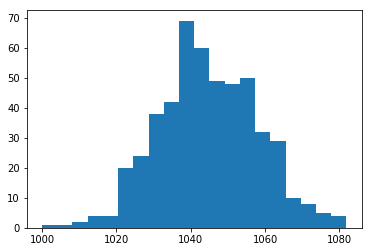

In [9]:
import matplotlib.pyplot as plt
dt=np.array(x)*1000/np.min(x)
plt.hist(dt,bins=20)
plt.show()

In [10]:
control_group=data[data["group"]=='control'].sample(n=required_n,random_state=42)
treatment_group=data[data["group"]=='treatment'].sample(n=required_n,random_state=42)
df=pd.concat([control_group,treatment_group], axis=0)

In [11]:
dfg=df.groupby("group")["converted"].agg(['mean',"std","count","sum"]).reset_index()
dfg["std_err"]=dfg["std"]/(dfg["count"]**(1/2))
dfg


,group,mean,std,count,sum,std_err
0,control,0.115651,0.319836,5335,617,0.004379
1,treatment,0.128210,0.334355,5335,684,0.004578


Seems treatment group made things little better. The conversion rate went little up than what we expected. The average conversion rate of control group was lower than what we thought.

Is the difference Statistically significant. Since, we have very large sample lets assume it follow central limit theorem and poportion based use z-test
===

In [12]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

successes = [dfg["sum"][0], dfg["sum"][1]]
nobs = [dfg["count"][0], dfg["count"][1]]
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.98
p-value: 0.047
ci 95% for control group: [0.107, 0.124]
ci 95% for treatment group: [0.119, 0.137]


Since, P-value <alpha, There is significant difference in conversion rate among two groups. Reject Null Hypothesis
==

Independant  sample T-TEST
===========
Assumption 1: Are the two samples independent? 

Assumption 2: Are the data from each of the 2 groups following a normal distribution?

Assumption 3: Do the two samples have the same variances (Homogeneity of Variance)?

In [9]:
import pandas as pd
data = 'https://gist.githubusercontent.com/baskaufs/1a7a995c1b25d6e88b45/raw/4bb17ccc5c1e62c27627833a4f25380f27d30b35/t-test.csv'
df = pd.read_csv(data)
df.head()
df_men=df[df["grouping"]=='men']
df_women=df[df["grouping"]=='women']
df.corr()

,height
height,1.0


In [10]:
df.groupby("grouping").describe()

height                                                           
          count        mean       std    min     25%    50%     75%    max
grouping                                                                  
men         7.0  179.871429  6.216836  169.0  176.80  181.5  183.85  187.3
women       7.0  171.057143  5.697619  165.2  166.65  170.3  173.75  181.1

In [6]:
df_men["height"].corr(df_women["height"])

nan

Assumption 2: Are the data from each of the 2 groups following a normal distribution?
===
Ho=Sample is normally dirtributed

perform Shapiro-Wilks test, Histogram, Q-Q plot

In [15]:
import scipy.stats as stats
#Shapiro-Wilks test
stats.shapiro(df_men["height"])

ShapiroResult(statistic=0.9550848603248596, pvalue=0.7756242156028748)

In [16]:
stats.shapiro(df_women["height"])

ShapiroResult(statistic=0.9197608828544617, pvalue=0.467536598443985)

P-value is greater than alpha hence accept null hypotheis

Assumption 3: Do the two samples have the same variances (Homogeneity of Variance)?
==
if  data does not fulfill the assumption of equal variances, we can use Welch’s t-test instead of Student’s t-test
Ho=Both sample has same variance

Perform levene TEST

In [20]:
stats.levene(df_men["height"], df_women["height"])

LeveneResult(statistic=0.026695150465104206, pvalue=0.8729335280501348)

In [23]:
from statsmodels.stats.weightstats import ttest_ind
result=ttest_ind(df_men["height"], df_women["height"])
print( "T-stat:",result[0],"P-value:",result[1],"Degree of Freedom:",result[2])

T-stat: 2.765444762721087 P-value: 0.017105701528166175 Degree of Freedom: 12.0


Paired T-Test
==========
scipy.stats.ttest_rel

Chi-square TEST
===
The table has interest of male and females in three subject math, science, art

Ho: Interests do not depend on gender Or interest is independent of gender

In [29]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

table = [	[10, 20, 30],
			[6,  9,  17]]
stat, p, dof, expected=chi2_contingency(table)
